# Import libraries

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter
import networkx as nx
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf

# Import xml

In [19]:
G = nx.read_graphml('./london.graph.xml')

In [20]:
type(G)

networkx.classes.graph.Graph

In [21]:
# list all operations of the G object
print(len(dir(G)))
for i in np.random.randint(0, len(dir(G)), 10):
    print(dir(G)[i])

76
__dict__
__ge__
graph
graph_attr_dict_factory
__dict__
__ne__
__dir__
__setattr__
degree
size


In [22]:
print(G.number_of_nodes())
print(G.number_of_edges())

401
467


# Creat network

In [23]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [24]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [25]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [26]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [27]:
original_nodes = set(G.nodes())

isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)

updated_nodes = set(G.nodes())

removed_nodes = original_nodes - updated_nodes

print("Removed nodes:", removed_nodes)

Removed nodes: set()


In [28]:
extra_edges_removed = []

for u, v in list(G.edges()):
    if G.number_of_edges(u, v) > 1:
        # 获取这对节点之间所有多余的边
        extra_edges = list(G.edges(u, v))[1:]  
        extra_edges_removed.extend(extra_edges)  
        G.remove_edges_from(extra_edges) 

print("Removed extra edges:", extra_edges_removed)

Removed extra edges: []


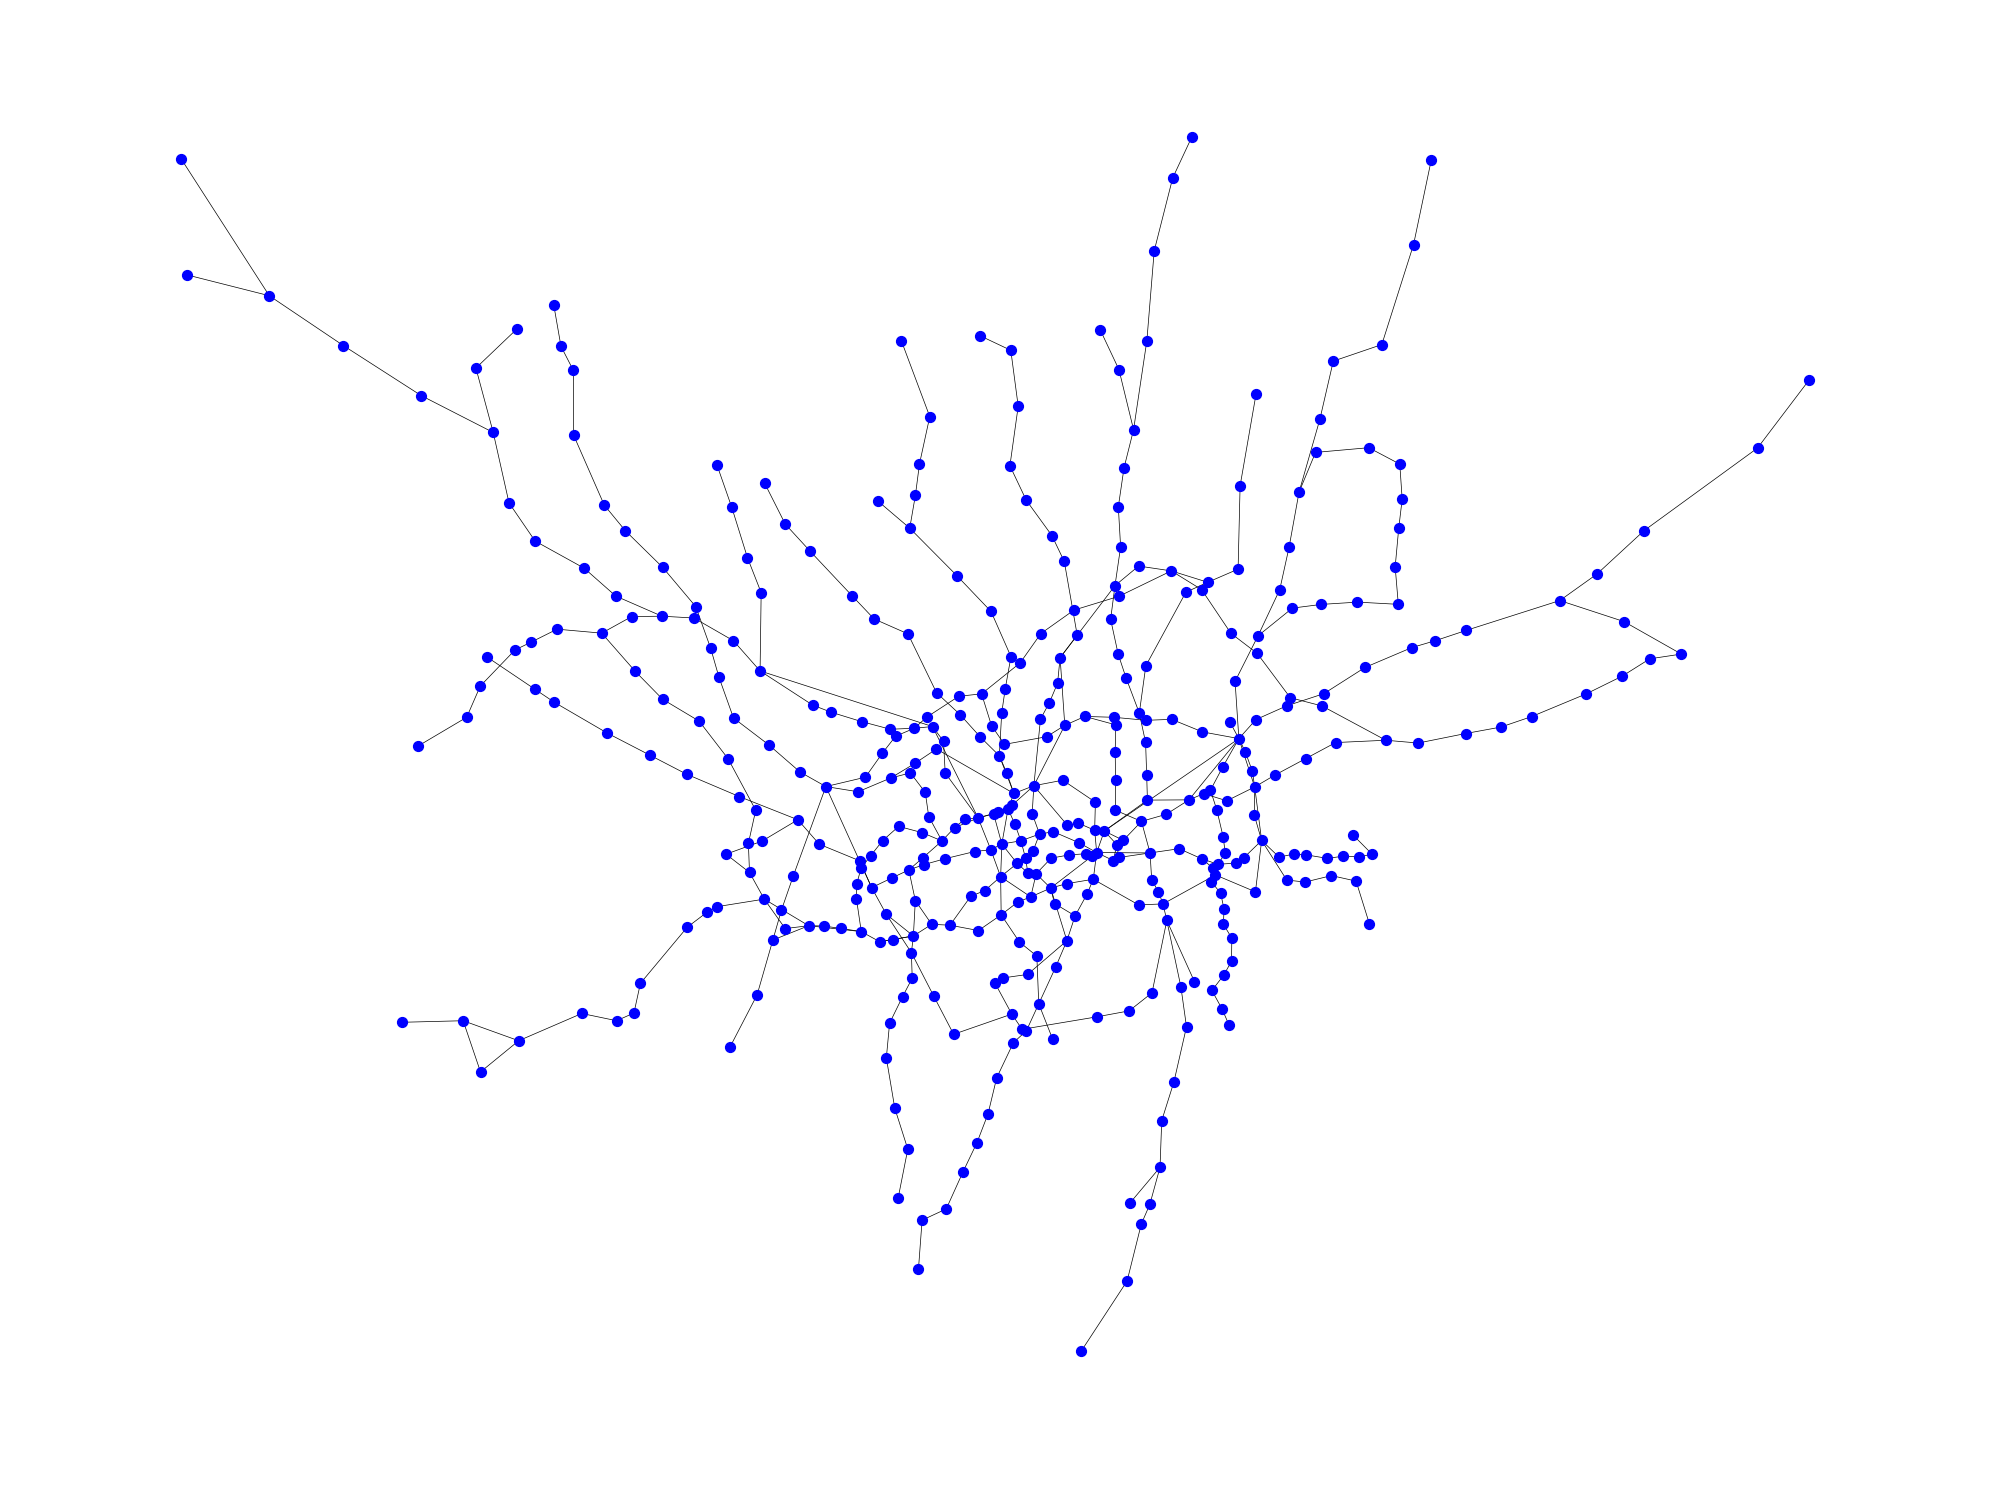

In [29]:
fig, ax = plt.subplots(figsize=(20,15))

node_labels = {node: node for node in G.nodes()} 

pos = nx.get_node_attributes(G, 'coords') 

nx.draw_networkx_nodes(G, pos, node_size=50, node_color='b')
nx.draw_networkx_edges(G, pos, arrows=False, width=0.5)

plt.axis("off")
plt.tight_layout() 
plt.savefig("outputs/T_London_Underground_Network.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
df = nx.to_pandas_edgelist(G)
df[0:10]

,source,target,line_name,flows,length
0,Wembley Park,Kingsbury,Jubilee,12356,2916.771558
1,Wembley Park,Neasden,Jubilee,6744,2353.165938
2,Wembley Park,Preston Road,Metropolitan,36601,1419.735166
3,Wembley Park,Finchley Road,Metropolitan,55216,7266.373927
4,Kingsbury,Queensbury,Jubilee,9419,1245.995234
5,Queensbury,Canons Park,Jubilee,6385,1693.307343
6,Canons Park,Stanmore,Jubilee,3624,1419.669476
7,Stratford,West Ham,Jubilee,91801,1673.509515
8,Stratford,Mile End,Central,12010,2805.001392
9,Stratford,Leyton,Central,56082,2131.342926


# Topological network

## Measurement of topological centrality

### Degree centrality

In [31]:
G_deg = G.copy()

In [32]:
deg_london = nx.degree_centrality(G_deg)
nx.set_node_attributes(G_deg, dict(deg_london), 'degree')

In [33]:
# To dataframe using the nodes as the index
df_deg = pd.DataFrame(index=G_deg.nodes())
df_deg['degree'] = pd.Series(nx.get_node_attributes(G_deg, 'degree'))

df_deg_updated_initial = df_deg.sort_values(["degree"], ascending=False)
df_deg_updated_initial.head(10)

,degree
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Earl's Court,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150
Waterloo,0.0150
Green Park,0.0150
Canning Town,0.0150


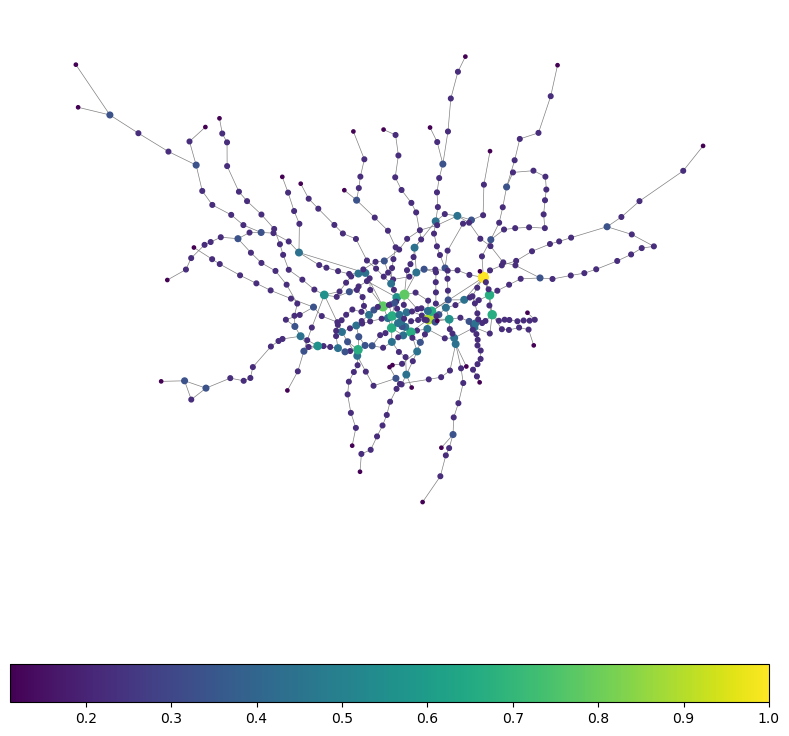

In [40]:
# Lets set colour and size of nodes according to betweenness values
deg_london_values=[(i[1]['degree']) for i in G_deg.nodes(data=True)]

deg_london_color=[(i[1]['degree']/(max(deg_london_values))) for i in G_deg.nodes(data=True)]
deg_london_size=[(i[1]['degree']/(max(deg_london_values)))*50 for i in G_deg.nodes(data=True)]

# Plot graph
pos=pos

fig, ax = plt.subplots(figsize=(8,8))

nx.draw_networkx_edges(G_deg, pos,edge_color='gray', 
        width=0.5)
nod=nx.draw_networkx_nodes(G_deg,
        pos = pos,
        node_color= deg_london_color,
        node_size= deg_london_size)

plt.colorbar(nod,orientation="horizontal", shrink=1)
plt.axis("off")
plt.tight_layout()
plt.savefig("outputs/T_Degree_Centrality.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

### Closeness centrality

In [35]:
G_clo = G.copy()

In [36]:
clo_london = nx.closeness_centrality(G_clo)
nx.set_node_attributes(G_clo,clo_london,'closeness')

In [37]:
# To ataframe using the nodes as the index
df_clo = pd.DataFrame(index=G_clo.nodes())
df_clo['closeness'] = pd.Series(nx.get_node_attributes(G_clo, 'closeness'))

df_clo_initial = df_clo.sort_values(["closeness"], ascending=False)
df_clo_initial.head(10)

,closeness
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


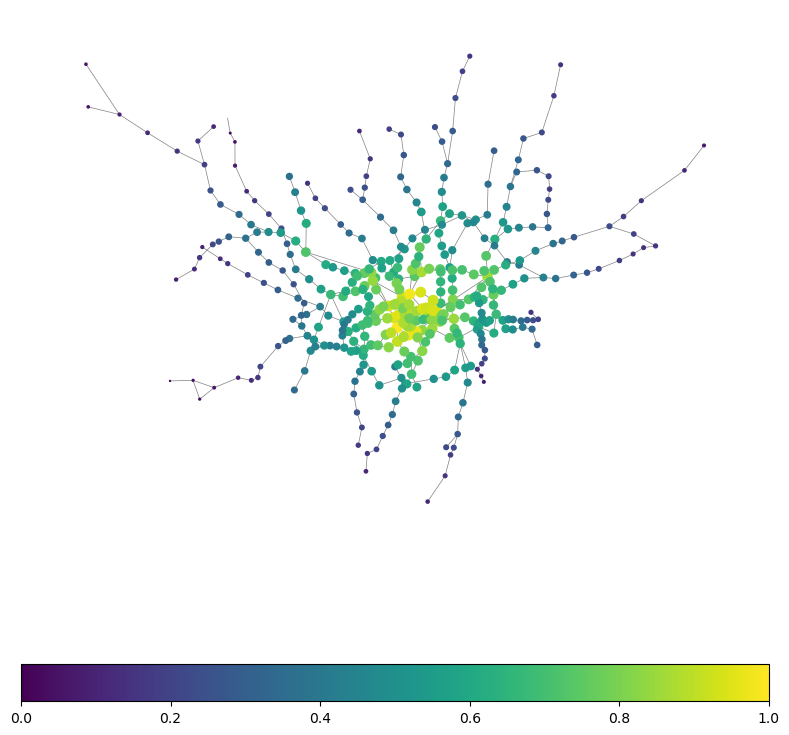

In [39]:
clo_london_values=[(i[1]['closeness']) for i in G_clo.nodes(data=True)]

clo_london_color=[(i[1]['closeness']-min(clo_london_values))/(max(clo_london_values)-min(clo_london_values)) for i in G_clo.nodes(data=True)]
clo_london_size=[((i[1]['closeness']-min(clo_london_values))/(max(clo_london_values)-min(clo_london_values))*50) for i in G_clo.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(8,8))

nx.draw_networkx_edges(G_clo, pos,edge_color='gray', 
        width=0.5)

nod=nx.draw_networkx_nodes(G_clo,
        pos = pos,
        node_color= clo_london_color,
        node_size= clo_london_size)

plt.colorbar(nod,orientation="horizontal", shrink=1)
plt.axis("off")
plt.tight_layout()
plt.savefig("outputs/T_Closeness_Centrality.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

### 中介中心性

In [41]:
G_bet = G.copy()

In [42]:
bet_london=nx.betweenness_centrality(G_bet, normalized=False)
nx.set_node_attributes(G_bet,dict(bet_london),'betweenness')

In [43]:
df_bet = pd.DataFrame(index=G_bet.nodes())
df_bet['betweenness'] = pd.Series(nx.get_node_attributes(G_bet, 'betweenness'))

df_bet_initial = df_bet.sort_values(["betweenness"], ascending=False)
df_bet_initial.head(10)

,betweenness
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


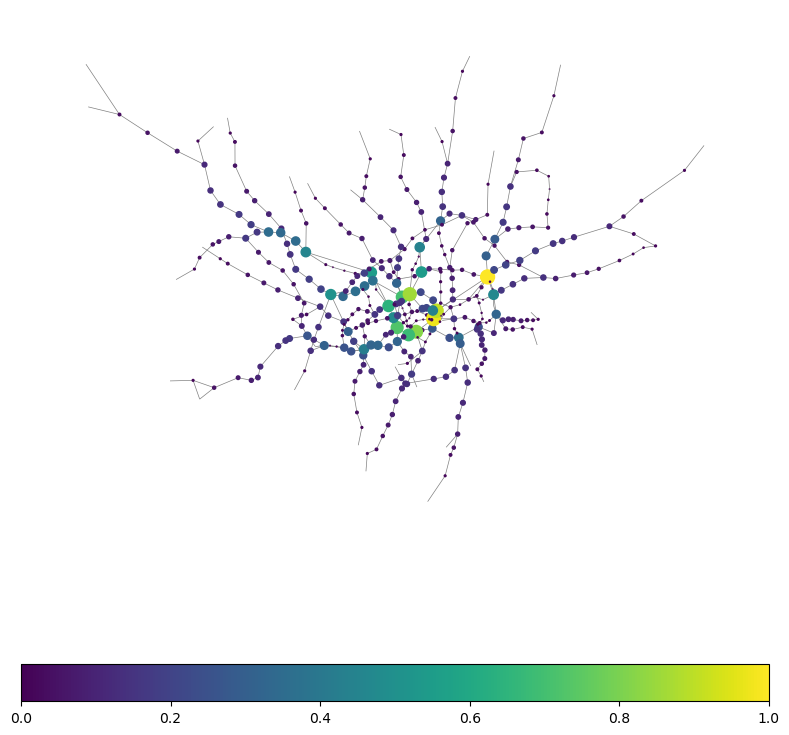

In [44]:
# Lets set colour and size of nodes according to betweenness values
bet_london_values=[(i[1]['betweenness']) for i in G_bet.nodes(data=True)]

bet_london_color=[(i[1]['betweenness']/max(bet_london_values)) for i in G_bet.nodes(data=True)]
bet_london_size=[(i[1]['betweenness']/max(bet_london_values))*100 for i in G_bet.nodes(data=True)]

# Plot graph
pos=pos

fig, ax = plt.subplots(figsize=(8,8))

nx.draw_networkx_edges(G_bet, pos,edge_color='gray', 
        width=0.5)
nod=nx.draw_networkx_nodes(G_bet,
        pos = pos,
        node_color= bet_london_color,
        node_size= bet_london_size)

plt.colorbar(nod,orientation="horizontal", shrink=1)
plt.axis("off")
plt.tight_layout()
plt.savefig("outputs/T_Betweenness_Centrality.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

## Impact measures

### E

In [45]:
G_efficiency = G.copy()

In [46]:
initial_efficiency = nx.global_efficiency(G)
print("Initial Network Efficiency:", initial_efficiency)

Initial Network Efficiency: 0.1012561935972123


### LCC

In [47]:
G_components = G.copy()

In [48]:
initial_components = list(nx.connected_components(G_components))

initial_largest_component = max(initial_components, key=len)

G_components_initial_largest = G_components.subgraph(initial_largest_component).copy()

print("nodes：", G_components_initial_largest.number_of_nodes())
print("edges：", G_components_initial_largest.number_of_edges())

nodes： 401
edges： 467


## Node Removal

### Strategy A

#### A - deg

In [49]:
G_deg_a = G.copy()

In [50]:
deg_london_a = nx.degree_centrality(G_deg_a)
nx.set_node_attributes(G_deg_a, dict(deg_london_a), 'degree')

In [51]:
# 将节点信息转换为DataFrame，并按度中心性降序排序
df_deg_a = pd.DataFrame(index=G_deg_a.nodes())
df_deg_a['degree'] = pd.Series(nx.get_node_attributes(G_deg_a, 'degree'))

df_deg_a_updated = df_deg_a.sort_values(["degree"], ascending=False)
df_deg_a_updated.head(10)

,degree
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Earl's Court,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150
Waterloo,0.0150
Green Park,0.0150
Canning Town,0.0150


In [52]:
df_deg_a_results = pd.DataFrame(columns=["Removed Node", "Network Efficiency", "Largest Connected Component", "Number of Nodes", "Number of Edges"])

for node in df_deg_a_updated.head(10).index:
    
    G_deg_a.remove_node(node)
    
    deg_a_efficiency = nx.global_efficiency(G_deg_a)
    
    deg_a_components = list(nx.connected_components(G_deg_a))
    
    deg_a_largest_component = max(deg_a_components, key=len)
    
    G_deg_a_largest = G_deg_a.subgraph(deg_a_largest_component).copy()
    
    deg_a_num_nodes = G_deg_a_largest.number_of_nodes()
    deg_a_num_edges = G_deg_a_largest.number_of_edges()
    
    deg_a_temp_df = pd.DataFrame({
        "Removed Node": [node], 
        "Network Efficiency": [deg_a_efficiency], 
        "Largest Connected Component": [len(deg_a_largest_component)],
        "Number of Nodes": [deg_a_num_nodes],
        "Number of Edges": [deg_a_num_edges]
    })
    
    df_deg_a_results = pd.concat([df_deg_a_results, deg_a_temp_df], ignore_index=True)

df_deg_a_results.head(10)

/tmp/ipykernel_3952/4150098284.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_deg_a_results = pd.concat([df_deg_a_results, deg_a_temp_df], ignore_index=True)


,Removed Node,Network Efficiency,Largest Connected Component,Number of Nodes,Number of Edges
0,Stratford,0.088917,379,379,438
1,Bank and Monument,0.085862,378,378,430
2,King's Cross St. Pancras,0.080287,377,377,423
3,Baker Street,0.075700,374,374,415
4,Earl's Court,0.074036,373,373,409
5,Oxford Circus,0.072745,371,371,403
6,Liverpool Street,0.070948,365,365,395
7,Waterloo,0.068982,364,364,390
8,Green Park,0.068257,363,363,385
9,Canning Town,0.063384,349,349,368


#### A - clo

In [53]:
G_clo_a = G.copy()

In [54]:
clo_london_a = nx.closeness_centrality(G_clo_a)
nx.set_node_attributes(G_clo_a, clo_london_a, 'closeness') 

In [55]:
df_clo_a = pd.DataFrame(index=G_clo_a.nodes())
df_clo_a['closeness'] = pd.Series(nx.get_node_attributes(G_clo_a, 'closeness'))

df_clo_a_updated = df_clo_a.sort_values(["closeness"], ascending=False)
df_clo_a_updated.head(10)

,closeness
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


In [56]:
df_clo_a_results = pd.DataFrame(columns=["Removed Node", "Network Efficiency", "Largest Connected Component", "Number of Nodes", "Number of Edges"])

# Remove the top 10 nodes with the highest closeness centrality one by one
for node in df_clo_a_updated.head(10).index:
    # Remove the node
    G_clo_a.remove_node(node)
    
    # Calculate global efficiency
    clo_a_efficiency = nx.global_efficiency(G_clo_a)
    
    # Find all connected components
    clo_a_components = list(nx.connected_components(G_clo_a))
    
    # Find the largest connected component
    clo_a_largest_component = max(clo_a_components, key=len)
    
    # Create a subgraph containing only the nodes of the largest connected component
    G_clo_a_largest = G_clo_a.subgraph(clo_a_largest_component).copy()
    
    # Get the number of nodes and edges
    clo_a_num_nodes = G_clo_a_largest.number_of_nodes()
    clo_a_num_edges = G_clo_a_largest.number_of_edges()
    
    # Create a single-row DataFrame and merge it into the results DataFrame
    clo_a_temp_df = pd.DataFrame({
        "Removed Node": [node], 
        "Network Efficiency": [clo_a_efficiency], 
        "Largest Connected Component": [len(clo_a_largest_component)],
        "Number of Nodes": [clo_a_num_nodes],
        "Number of Edges": [clo_a_num_edges]
    })
    
    df_clo_a_results = pd.concat([df_clo_a_results, clo_a_temp_df], ignore_index=True)

# Display the results
df_clo_a_results.head(10)

/tmp/ipykernel_3952/2050299995.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_clo_a_results = pd.concat([df_clo_a_results, clo_a_temp_df], ignore_index=True)


,Removed Node,Network Efficiency,Largest Connected Component,Number of Nodes,Number of Edges
0,Green Park,0.099190,400,400,461
1,Bank and Monument,0.094872,399,399,453
2,King's Cross St. Pancras,0.087934,398,398,446
3,Westminster,0.087372,397,397,443
4,Waterloo,0.084859,396,396,439
5,Oxford Circus,0.082781,395,395,434
6,Bond Street,0.082581,394,394,432
7,Farringdon,0.082600,393,393,431
8,Angel,0.082622,392,392,430
9,Moorgate,0.081670,389,389,427


#### A - bet

In [57]:
G_bet_a = G.copy()

In [58]:
bet_london_a = nx.betweenness_centrality(G_bet_a, normalized=False)
nx.set_node_attributes(G_bet_a, bet_london_a, 'betweenness')

In [59]:
df_bet_a = pd.DataFrame(index=G_bet_a.nodes())
df_bet_a['betweenness'] = pd.Series(nx.get_node_attributes(G_bet_a, 'betweenness'))
df_bet_a_updated = df_bet_a.sort_values(["betweenness"], ascending=False)
df_bet_a_updated.head(10)

,betweenness
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


In [60]:
# Create DataFrame to store the results after each node removal
df_bet_a_results = pd.DataFrame(columns=["Removed Node", "Network Efficiency", "Largest Connected Component", "Number of Nodes", "Number of Edges"])

# Remove the top 10 nodes with the highest betweenness centrality one by one
for node in df_bet_a_updated.head(10).index:
    # Remove the node
    G_bet_a.remove_node(node)
    
    # Calculate global efficiency
    bet_a_efficiency = nx.global_efficiency(G_bet_a)
    
    # Find all connected components
    bet_a_components = list(nx.connected_components(G_bet_a))
    
    # Find the largest connected component
    bet_a_largest_component = max(bet_a_components, key=len)
    
    # Create a subgraph containing only the nodes of the largest connected component
    G_bet_a_largest = G_bet_a.subgraph(bet_a_largest_component).copy()
    
    # Get the number of nodes and edges
    bet_a_num_nodes = G_bet_a_largest.number_of_nodes()
    bet_a_num_edges = G_bet_a_largest.number_of_edges()
    
    # Create a single-row DataFrame and merge it into the results DataFrame
    bet_a_temp_df = pd.DataFrame({
        "Removed Node": [node], 
        "Network Efficiency": [bet_a_efficiency], 
        "Largest Connected Component": [len(bet_a_largest_component)],
        "Number of Nodes": [bet_a_num_nodes],
        "Number of Edges": [bet_a_num_edges]
    })
    
    df_bet_a_results = pd.concat([df_bet_a_results, bet_a_temp_df], ignore_index=True)

# Display the results
df_bet_a_results.head(10)

/tmp/ipykernel_3952/751875377.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_bet_a_results = pd.concat([df_bet_a_results, bet_a_temp_df], ignore_index=True)


,Removed Node,Network Efficiency,Largest Connected Component,Number of Nodes,Number of Edges
0,Stratford,0.088917,379,379,438
1,Bank and Monument,0.085862,378,378,430
2,Liverpool Street,0.084963,377,377,426
3,King's Cross St. Pancras,0.078498,371,371,415
4,Waterloo,0.075942,370,370,410
5,Green Park,0.074152,369,369,404
6,Euston,0.068206,346,346,379
7,Westminster,0.067660,345,345,377
8,Baker Street,0.064700,342,342,369
9,Finchley Road,0.063139,339,339,365


### Strategy B

#### B - deg

In [61]:
G_deg_b = G.copy()

In [62]:
deg_london_b = nx.degree_centrality(G_deg_b)
nx.set_node_attributes(G_deg_b, dict(deg_london_b), 'degree')

In [63]:
df_deg_b = pd.DataFrame(index=G_deg_b.nodes())
df_deg_b['degree'] = pd.Series(nx.get_node_attributes(G_deg_b, 'degree'))

df_deg_b_updated = df_deg_b.sort_values(["degree"], ascending=False)
df_deg_b_updated.head(10)

,degree
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Earl's Court,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150
Waterloo,0.0150
Green Park,0.0150
Canning Town,0.0150


In [64]:
# Create DataFrame to store the results after each node removal
df_deg_b_results = pd.DataFrame(columns=["Removed Node", "Network Efficiency", "Largest Connected Component", "Number of Nodes", "Number of Edges"])

# Loop to remove the node with the highest degree centrality, 10 times
for _ in range(10):
    # Calculate the current graph's degree centrality and set it as a node attribute
    deg_london_b = nx.degree_centrality(G_deg_b)
    nx.set_node_attributes(G_deg_b, deg_london_b, 'degree')
    
    # Convert node information to DataFrame and sort by degree centrality in descending order
    df_deg_b = pd.DataFrame(index=G_deg_b.nodes())
    df_deg_b['degree'] = pd.Series(nx.get_node_attributes(G_deg_b, 'degree'))
    df_deg_b_updated = df_deg_b.sort_values(["degree"], ascending=False)
    
    # Select the node with the highest degree centrality
    deg_b_top_node = df_deg_b_updated.index[0]
    
    # Remove that node
    G_deg_b.remove_node(deg_b_top_node)
    
    # Calculate global efficiency after node removal
    deg_b_efficiency = nx.global_efficiency(G_deg_b)
    
    # Find all connected components
    deg_b_components = list(nx.connected_components(G_deg_b))
    
    # Find the largest connected component
    deg_b_largest_component = max(deg_b_components, key=len)
    
    # Create a subgraph containing only the nodes of the largest connected component
    G_deg_b_largest = G_deg_b.subgraph(deg_b_largest_component).copy()
    
    # Number of nodes and edges in the largest component
    deg_b_num_nodes = G_deg_b_largest.number_of_nodes()
    deg_b_num_edges = G_deg_b_largest.number_of_edges()
    
    # 添加结果到DataFrame中
    deg_b_temp_df = pd.DataFrame({
        "Removed Node": [deg_b_top_node], 
        "Network Efficiency": [deg_b_efficiency], 
        "Largest Connected Component": [len(deg_b_largest_component)],
        "Number of Nodes": [deg_b_num_nodes],
        "Number of Edges": [deg_b_num_edges]
    }, index=[0])  # 指定index

    df_deg_b_results = pd.concat([df_deg_b_results, deg_b_temp_df], ignore_index=True)


# Display the results
df_deg_b_results.head(10)

/tmp/ipykernel_3952/706715935.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_deg_b_results = pd.concat([df_deg_b_results, deg_b_temp_df], ignore_index=True)


,Removed Node,Network Efficiency,Largest Connected Component,Number of Nodes,Number of Edges
0,Stratford,0.088917,379,379,438
1,Bank and Monument,0.085862,378,378,430
2,Baker Street,0.082033,377,377,423
3,King's Cross St. Pancras,0.075700,374,374,415
4,Earl's Court,0.074036,373,373,409
5,Green Park,0.073004,372,372,403
6,Canning Town,0.067772,358,358,386
7,Willesden Junction,0.060128,344,344,369
8,Turnham Green,0.058145,338,338,360
9,Oxford Circus,0.056859,336,336,355


#### B - clo

In [65]:
G_clo_b = G.copy()

In [66]:
clo_london_b = nx.closeness_centrality(G_clo_b)
nx.set_node_attributes(G_clo_b, dict(clo_london_b), 'closeness') 

In [67]:
df_clo_b = pd.DataFrame(index=G_clo_b.nodes())
df_clo_b['closeness'] = pd.Series(nx.get_node_attributes(G_clo_b, 'closeness'))

df_clo_b_updated = df_clo_b.sort_values(["closeness"], ascending=False)
df_clo_b_updated.head(10)

,closeness
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


In [68]:
# Create DataFrame to store the results after each node removal
df_clo_b_results = pd.DataFrame(columns=["Removed Node", "Network Efficiency", "Largest Connected Component", "Number of Nodes", "Number of Edges"])

# Loop to remove the node with the highest closeness centrality, 10 times
for _ in range(10):
    # Calculate the current graph's closeness centrality and set it as a node attribute
    clo_london_b = nx.closeness_centrality(G_clo_b)
    nx.set_node_attributes(G_clo_b, clo_london_b, 'closeness')
    
    # Convert node information to DataFrame and sort by closeness centrality in descending order
    df_clo_b = pd.DataFrame(index=G_clo_b.nodes())
    df_clo_b['closeness'] = pd.Series(nx.get_node_attributes(G_clo_b, 'closeness'))
    df_clo_b_updated = df_clo_b.sort_values(["closeness"], ascending=False)
    
    # Select the node with the highest closeness centrality
    clo_b_top_node = df_clo_b_updated.index[0]
    
    # Remove that node
    G_clo_b.remove_node(clo_b_top_node)
    
    # Calculate global efficiency after node removal
    clo_b_efficiency = nx.global_efficiency(G_clo_b)
    
    # Find all connected components
    clo_b_components = list(nx.connected_components(G_clo_b))
    
    # Find the largest connected component
    clo_b_largest_component = max(clo_b_components, key=len)
    
    # Create a subgraph containing only the nodes of the largest connected component
    G_clo_b_largest = G_clo_b.subgraph(clo_b_largest_component).copy()
    
    # Number of nodes and edges in the largest component
    clo_b_num_nodes = G_clo_b_largest.number_of_nodes()
    clo_b_num_edges = G_clo_b_largest.number_of_edges()
    
    # Add the results to the DataFrame
    clo_b_temp_df = pd.DataFrame({
        "Removed Node": [clo_b_top_node], 
        "Network Efficiency": [clo_b_efficiency], 
        "Largest Connected Component": [len(clo_b_largest_component)],
        "Number of Nodes": [clo_b_num_nodes],
        "Number of Edges": [clo_b_num_edges]
    }, index=[0])  # Specify index

    df_clo_b_results = pd.concat([df_clo_b_results, clo_b_temp_df], ignore_index=True)

# Display the results
df_clo_b_results.head(10)

/tmp/ipykernel_3952/1134751448.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_clo_b_results = pd.concat([df_clo_b_results, clo_b_temp_df], ignore_index=True)


,Removed Node,Network Efficiency,Largest Connected Component,Number of Nodes,Number of Edges
0,Green Park,0.099190,400,400,461
1,King's Cross St. Pancras,0.094435,399,399,454
2,Waterloo,0.091816,398,398,448
3,Bank and Monument,0.085426,397,397,441
4,West Hampstead,0.080544,396,396,437
5,Canada Water,0.058101,226,226,248
6,Stratford,0.051884,226,226,248
7,Earl's Court,0.050350,225,225,242
8,Shepherd's Bush,0.044395,195,195,210
9,Oxford Circus,0.042958,194,194,205


#### B - bet

In [69]:
G_bet_b = G.copy()

In [70]:
bet_london_b =nx.betweenness_centrality(G_bet_b, normalized=False)
nx.set_node_attributes(G_bet_b,dict(bet_london_b),'betweenness')

In [71]:
df_bet_b = pd.DataFrame(index=G_bet_b.nodes())
df_bet_b['betweenness'] = pd.Series(nx.get_node_attributes(G_bet_b, 'betweenness'))

df_bet_b_updated = df_bet_b.sort_values(["betweenness"], ascending=False)
df_bet_b_updated.head(10)

,betweenness
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


In [72]:
df_bet_b_results = pd.DataFrame(columns=["Removed Node", "Network Efficiency", "Largest Connected Component", "Number of Nodes", "Number of Edges"])

for _ in range(10):
    
    bet_london_b = nx.betweenness_centrality(G_bet_b, normalized=False)
    nx.set_node_attributes(G_bet_b, bet_london_b, 'betweenness')
    
    df_bet_b = pd.DataFrame(index=G_bet_b.nodes())
    df_bet_b['betweenness'] = pd.Series(nx.get_node_attributes(G_bet_b, 'betweenness'))
    df_bet_b_updated = df_bet_b.sort_values(["betweenness"], ascending=False)
    
    bet_b_top_node = df_bet_b_updated.index[0]
    
    G_bet_b.remove_node(bet_b_top_node)
    
    bet_b_efficiency = nx.global_efficiency(G_bet_b)
    
    bet_b_components = list(nx.connected_components(G_bet_b))
    
    bet_b_largest_component = max(bet_b_components, key=len)
    
    G_bet_b_largest = G_bet_b.subgraph(bet_b_largest_component).copy()
    
    bet_b_num_nodes = G_bet_b_largest.number_of_nodes()
    bet_b_num_edges = G_bet_b_largest.number_of_edges()
    
    bet_b_temp_df = pd.DataFrame({
        "Removed Node": [bet_b_top_node], 
        "Network Efficiency": [bet_b_efficiency], 
        "Largest Connected Component": [len(bet_b_largest_component)],
        "Number of Nodes": [bet_b_num_nodes],
        "Number of Edges": [bet_b_num_edges]
    }, index=[0])

    df_bet_b_results = pd.concat([df_bet_b_results, bet_b_temp_df], ignore_index=True)

df_bet_b_results.head(10)

/tmp/ipykernel_3952/3362171101.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_bet_b_results = pd.concat([df_bet_b_results, bet_b_temp_df], ignore_index=True)


,Removed Node,Network Efficiency,Largest Connected Component,Number of Nodes,Number of Edges
0,Stratford,0.088917,379,379,438
1,King's Cross St. Pancras,0.084603,378,378,431
2,Waterloo,0.081829,377,377,425
3,Bank and Monument,0.077678,376,376,418
4,Canada Water,0.072832,375,375,414
5,West Hampstead,0.053210,227,227,254
6,Earl's Court,0.051656,226,226,248
7,Shepherd's Bush,0.045844,196,196,216
8,Euston,0.041631,173,173,191
9,Baker Street,0.038164,170,170,183


# Visualisation

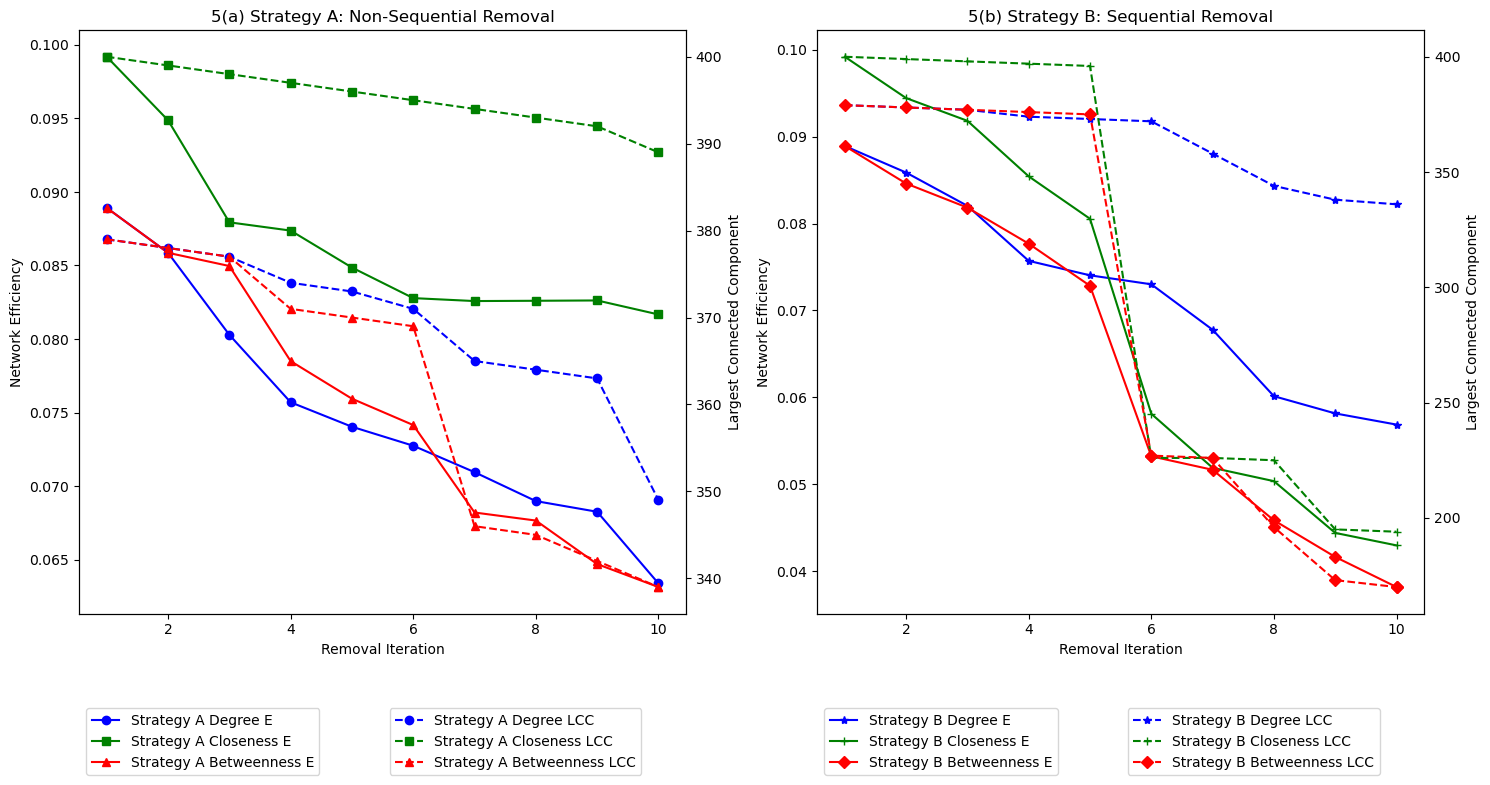

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1a = ax1.twinx()
ax1.plot(df_deg_a_results.index + 1, df_deg_a_results['Network Efficiency'], 'b-o', label='Strategy A Degree E')
ax1.plot(df_clo_a_results.index + 1, df_clo_a_results['Network Efficiency'], 'g-s', label='Strategy A Closeness E')
ax1.plot(df_bet_a_results.index + 1, df_bet_a_results['Network Efficiency'], 'r-^', label='Strategy A Betweenness E')
ax1.set_xlabel('Removal Iteration')
ax1.set_ylabel('Network Efficiency')
ax1.set_title('5(a) Strategy A: Non-Sequential Removal')

ax1a.plot(df_deg_a_results.index + 1, df_deg_a_results['Largest Connected Component'], 'b--o', label='Strategy A Degree LCC')
ax1a.plot(df_clo_a_results.index + 1, df_clo_a_results['Largest Connected Component'], 'g--s', label='Strategy A Closeness LCC')
ax1a.plot(df_bet_a_results.index + 1, df_bet_a_results['Largest Connected Component'], 'r--^', label='Strategy A Betweenness LCC')
ax1a.set_ylabel('Largest Connected Component')

ax1.legend(loc='upper left', bbox_to_anchor=(0, -0.15))
ax1a.legend(loc='upper left', bbox_to_anchor=(0.5, -0.15))

ax2a = ax2.twinx()
ax2.plot(df_deg_b_results.index + 1, df_deg_b_results['Network Efficiency'], 'b-*', label='Strategy B Degree E')
ax2.plot(df_clo_b_results.index + 1, df_clo_b_results['Network Efficiency'], 'g-+', label='Strategy B Closeness E')
ax2.plot(df_bet_b_results.index + 1, df_bet_b_results['Network Efficiency'], 'r-D', label='Strategy B Betweenness E')
ax2.set_xlabel('Removal Iteration')
ax2.set_ylabel('Network Efficiency')
ax2.set_title('5(b) Strategy B: Sequential Removal')

ax2a.plot(df_deg_b_results.index + 1, df_deg_b_results['Largest Connected Component'], 'b--*', label='Strategy B Degree LCC')
ax2a.plot(df_clo_b_results.index + 1, df_clo_b_results['Largest Connected Component'], 'g--+', label='Strategy B Closeness LCC')
ax2a.plot(df_bet_b_results.index + 1, df_bet_b_results['Largest Connected Component'], 'r--D', label='Strategy B Betweenness LCC')
ax2a.set_ylabel('Largest Connected Component')

ax2.legend(loc='upper left', bbox_to_anchor=(0, -0.15))
ax2a.legend(loc='upper left', bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.savefig("outputs/T_A_vs_B.png", format='png', dpi=300, bbox_inches='tight')
plt.show()